<center>
    <img src="img/scikit-learn-logo.png" width="40%" />
    <br />
    <h1>Robust and calibrated estimators with Scikit-Learn</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>)
    <br /><br />
    New York University
</center>

In [1]:
# Global imports and settings

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.max_open_warning"] = -1

# Print options
import numpy as np
np.set_printoptions(precision=3)

# Slideshow
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': 1440, 'height': 768, 'scroll': True, 'theme': 'simple'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
%%javascript
Reveal.addEventListener("slidechanged", function(event){ window.location.hash = "header"; });

<IPython.core.display.Javascript object>

# Motivation

_In theory,_
- Samples $x$ are drawn from a distribution $P$;
- As data increases, convergence towards the optimal model is guaranteed. 

_In practice,_
- A few samples may be distant from other samples:
    - either because they correspond to rare observations,
    - or because they are due to experimental errors;
- Data is finite:
    - outliers might strongly affect the resulting model.

_Today's goal:_ build models that are robust to outliers!

# Outline

* Motivation
* Bias-variance decomposition 
* Novelty and anomaly detection
* Robust regression
* Calibration

# Bias-variance decomposition

__Theorem.__ For the _squared error loss_, the bias-variance decomposition of the expected
generalization error at $X=\mathbf{x}$ is

$$
\mathbb{E}_{\cal L} \{ Err(\varphi_{\cal L}(\mathbf{x})) \} = \text{noise}(\mathbf{x}) + \text{bias}^2(\mathbf{x}) + \text{var}(\mathbf{x})
$$



<center>
    <img src="img/bv.png" width="50%" />
</center>

## Robustness and variance

- Low variance implies robustness to outliers
- High variance implies sensitivity to data pecularities


## Ensembling reduces variance (and increases robustness)

__Theorem.__ For the _squared error loss_, the bias-variance decomposition of the expected generalization error at $X=x$ is

$$
\mathbb{E}_{\cal L} \{ Err(\varphi_{\cal L}(\mathbf{x})) \} = \text{noise}(\mathbf{x}) + \text{bias}^2(\mathbf{x}) + \text{var}(\mathbf{x})
$$

where
\begin{align*}
\text{noise}(\mathbf{x}) &= Err(\varphi_B(\mathbf{x})), \\
\text{bias}^2(\mathbf{x}) &= (\varphi_B(\mathbf{x}) - \mathbb{E}_{{\cal L},\theta} \{ \varphi_{{\cal L},\theta}(\mathbf{x}) \} )^2, \\
\text{var}(\mathbf{x}) &= \rho(\mathbf{x}) \sigma^2_{{\cal L},\theta}(\mathbf{x}) + \frac{1 - \rho(\mathbf{x})}{M} \sigma^2_{{\cal L},\theta}(\mathbf{x}).
\end{align*}

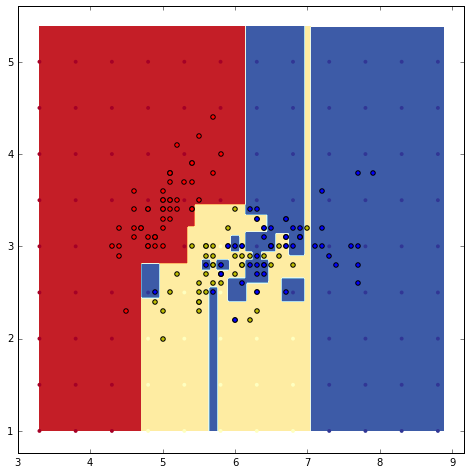

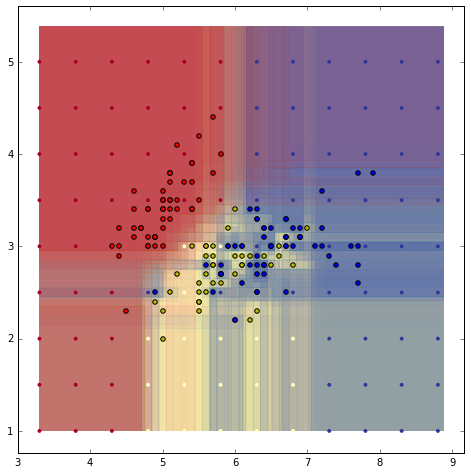

In [7]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from robustness import plot_surface

iris = load_iris()
X = iris.data[:, [0, 1]]
y = iris.target

clf = DecisionTreeClassifier().fit(X, y)
plot_surface(clf, X, y)

clf = RandomForestClassifier(n_estimators=100).fit(X, y)
plot_surface(clf, X, y)

# See also `sklearn.ensemble.BaggingClassifier` for ensembling any estimator

# Novelty and anomaly detection

In [ ]:
%load http://scikit-learn.org/dev/_downloads/plot_outlier_detection.py

# Robust regression

- robustscaler
- ransac
- huber
- gbrt 

In [ ]:
%load http://scikit-learn.org/dev/_downloads/plot_robust_scaling.py

In [ ]:
%load http://scikit-learn.org/dev/_downloads/plot_ransac.py

In [ ]:
%load http://scikit-learn.org/dev/_downloads/plot_huber_vs_ridge.py

# Calibration

In [ ]:
- lien avec regression

In [ ]:
%load http://scikit-learn.org/dev/_downloads/plot_calibration.py

In [ ]:
questions?